In [1]:
import os
import sys
from functools import partial

# Matplotlib and scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import minimize

# JAX stuff
import jax
jax.config.update("jax_enable_x64", True)
from jax import grad, value_and_grad
import jax.numpy as jnp

# OPTAX
import optax
import optax.tree_utils as otu

# Internal modules
current_file_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_file_dir, ".."))
sys.path.append(module_path)
from diffPLOG2TROE.falloff import compute_falloff
from diffPLOG2TROE.pressure_logarithmic import compute_plog
from diffPLOG2TROE.refitter import rmse_loss_function, compute_pressure_limits, run_lbfgs, print_info

# Refitting a PLOG into a TROE
1. First step compute the value of the kinetic constant of the PLOG across the ranges of pressure and temperature desired.
2. Compute first guess values for the TROE kinetic constant formalism, we will need the three arrhenius parameters both for the High pressure and low pressure limits and the four parameters of the TROE fitting formalism.
3. Run a global optimization to have reasonable values of the first guess. This should be fast something around 1s of wall time.
4. Run a gradient base optimizer to refine the solution (L-BFGS, adam, adabelief ...)
5. Finally evaluate the refitted constant by visual comparison, different plots are provided down below.

Keep in mind that providing already a reasonable first guess is crucial for the success of the refitting.

In [2]:
constant_plog = jnp.array([
    [1.00E-01, 7.23E+29, -5.32E+00, 110862.4],
    [1.00E+00, 3.50E+30, -5.22E+00, 111163.3],
    [1.00E+01, 1.98E+31, -5.16E+00, 111887.8],
    [1.00E+02, 2.69E+31, -4.92E+00, 112778.7],
], dtype=jnp.float64)

T_range = jnp.linspace(500, 2500, 100)
P_range = jnp.logspace(1.1, 1.7, 100)

print(f"Temperature range -> {T_range[0]} - {T_range[-1]}")
print(f"Pressure range    -> {P_range[0]} - {P_range[-1]}")

fg = jnp.array([
    1.98E+31, -5.16E+00, 111887.8,
    2.69E+31, -4.92E+00, 112778.7,
    0.1, 1., 1.0e+10, 1.0e+10
], dtype=jnp.float64)

# fg = compute_pressure_limits(constant_plog, fg, T_range, P_range)
k_plog = compute_plog(constant_plog, T_range, P_range)

Temperature range -> 500.0 - 2500.0
Pressure range    -> 12.589254117941675 - 50.11872336272722


In [3]:
%%time
# Global Optimization on all the parameters to have a better estimate of the parameters
data = (T_range, P_range, k_plog)
loss_function = rmse_loss_function
print(f"Initial value for the loss_function: {loss_function(fg, data)}")

# NELDER-MEAD
res = minimize(
    loss_function,
    fg,
    args=(data,),
    method="nelder-mead",
    options={
        "xatol": 1e-10,
        "fatol": 1e-15,
        "maxfev": 100000,
        "disp": True,
    }
)

fg_local = res.x

Initial value for the loss_function: 95.14410783455618
Optimization terminated successfully.
         Current function value: 0.003284
         Iterations: 3559
         Function evaluations: 5431
CPU times: user 2.37 s, sys: 257 ms, total: 2.63 s
Wall time: 1.12 s


In [6]:
%%time
#### OPTIMIZER PARAMETERS
MAXITER = 500
TOL = 1e-10
### Linesearch algorithm parameters
MAXLS_STEPS = 50
### ADDITIONAL OPTIONS
PRINT_FREQ=20
### Optimizer setup
opt = optax.chain(
    print_info(frequency=PRINT_FREQ),
    optax.lbfgs(
        linesearch=optax.scale_by_zoom_linesearch(
            max_linesearch_steps=MAXLS_STEPS,
            verbose=False
        )
    )
)

fg_work = fg_local.copy()
data = (T_range, P_range, k_plog)
loss_function = rmse_loss_function
loss_function = partial(loss_function, data=data)
print(
    f"Initial value: {loss_function(fg_work):.5E}"
    f" Initial gradient norm: {otu.tree_l2_norm(jax.grad(loss_function)(fg_work)):.5E}"
)
final_params, _ = run_lbfgs(
    fg_work,
    loss_function,
    opt,
    max_iter=MAXITER,
    tol=TOL,
)

print(
    f"Final value: {loss_function(final_params):.5E}, "
    f"Final gradient norm: {otu.tree_l2_norm(jax.grad(loss_function)(final_params)):.5E}"
)

Initial value: 3.28392E-03 Initial gradient norm: 4.03857E-04
Iteration: 0, Value: 0.003283916356143992, Gradient norm: 0.0004038573244923979
Iteration: 20, Value: 0.003283810640618017, Gradient norm: 5.525786305154813e-06
Iteration: 40, Value: 0.003283810640525519, Gradient norm: 2.7869008465348804e-07
Iteration: 60, Value: 0.0032838106393732473, Gradient norm: 1.3009580581634185e-06
Iteration: 80, Value: 0.0032838106156956857, Gradient norm: 7.02364254907535e-06
Iteration: 100, Value: 0.0032838104954707077, Gradient norm: 3.8100910777714644e-05
Iteration: 120, Value: 0.0032838088648462545, Gradient norm: 0.00036968244474381586
Iteration: 140, Value: 0.003283795240396694, Gradient norm: 7.457747482062836e-05
Iteration: 160, Value: 0.0032837915593784475, Gradient norm: 0.00030718785078398894
Iteration: 180, Value: 0.003283790993903795, Gradient norm: 0.00024084056105202556
Iteration: 200, Value: 0.003283786926400177, Gradient norm: 4.1188006013023344e-05
Iteration: 220, Value: 0.003283

In [7]:
refitted_troe = (
    jnp.array([
        [final_params[0], final_params[1], final_params[2], 0.000],  # HPL, the fourth term is dummy
        [final_params[3], final_params[4], final_params[5], 0.000],  # LPL, the fourth term is dummy
        [final_params[6], final_params[7], final_params[8], final_params[9]],  # TROE parameters
    ], dtype=jnp.float64),
    1, # Lindemann -> 0, TROE -> 1, SRI -> 2
)
k_refitted = compute_falloff(refitted_troe, T_range, P_range)

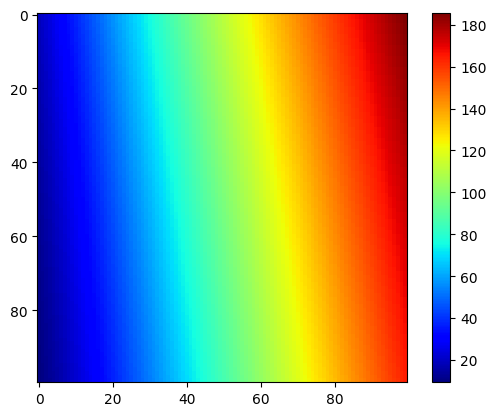

In [8]:
ratio = k_plog / k_refitted
fig, ax = plt.subplots()

c = ax.imshow(ratio, cmap='jet', interpolation='nearest')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

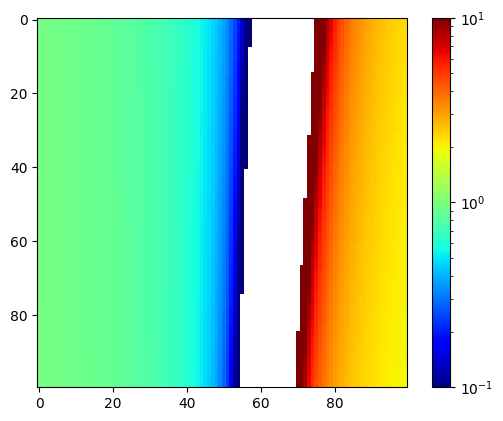

In [9]:
ratio = jnp.log(k_plog) / jnp.log(k_refitted)

vmin = 1e-1  # Set a custom lower value for the colormap
vmax = 1e1   # Set a custom upper value for the colormap
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots()
c = ax.imshow(ratio, cmap="jet", interpolation='none', norm=norm)
cbar = fig.colorbar(c, ax=ax)

plt.show()